# Creating Learning Model for Rust Detection on any Steels

# 1. Preparation

Importing all necessary library

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pydot
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import Model
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from shutil import copyfile

Defining paths

In [ ]:
source_dir = "/content/drive/MyDrive/Machine Learning"
norust = "/content/drive/MyDrive/Machine Learning/norust"
rust = "/content/drive/MyDrive/Machine Learning/rusts"

Renaming datasets / files

In [ ]:
# Rename file
norust_chdir = os.chdir(norust)
len(os.listdir(norust_chdir))

i = 0
for file in os.listdir(norust_chdir):
  new_file_name = "norust.{}.jpg".format(i)
  os.rename(file, new_file_name)
  i = i + 1

In [ ]:
rust_chdir = os.chdir(rust)
len(os.listdir(rust_chdir))

n = 0
for file in os.listdir(rust_chdir):
  new_file_name = "rusty.{}.jpg".format(n)
  os.rename(file, new_file_name)
  n = n + 1

In [ ]:
!pwd

/content


In [ ]:
# Re-check order
for files in os.listdir(norust_chdir):
    print(files)

for file in os.listdir(rust_chdir):
    print(file)

Creating directory for training set and testing set

In [ ]:
# Create Directory
os.makedirs(os.path.join(source_dir, 'training'))
os.makedirs(os.path.join(f'{source_dir}/training', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/training', 'norust'))
os.makedirs(os.path.join(source_dir, 'testing'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'norust'))

Defining training and testing directory path

In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/Machine Learning/training"
VALIDATION_DIR = "/content/drive/MyDrive/Machine Learning/testing"

TRAINING_N_DIR = "/content/drive/MyDrive/Machine Learning/training/norust"
TRAINING_R_DIR = "/content/drive/MyDrive/Machine Learning/training/rust"
TESTING_N_DIR = "/content/drive/MyDrive/Machine Learning/testing/norust"
TESTING_R_DIR = "/content/drive/MyDrive/Machine Learning/testing/rust"

# 2. Splitting datasets into Training and Validation

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    files = os.listdir(SOURCE_DIR)
    random.shuffle(files)

    split = int(len(files) * SPLIT_SIZE)

    for i, filename in enumerate(files):
        if os.path.getsize(os.path.join(SOURCE_DIR, filename)) == 0:
            print(f'{filename} is zero length, so ignoring.')
            continue

        if i < split:
            destination = os.path.join(TRAINING_DIR, filename)
        else:
            destination = os.path.join(VALIDATION_DIR, filename)

        source = os.path.join(SOURCE_DIR, filename)
        copyfile(source, destination)

In [ ]:
split_size= 0.8
split_data(norust, TRAINING_N_DIR, TESTING_N_DIR, split_size)
split_data(rust, TRAINING_R_DIR, TESTING_R_DIR, split_size)

print(f"\n\nOriginal norust's directory has {len(os.listdir(norust))} images")
print(f"Original rust's directory has {len(os.listdir(rust))} images\n")
print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")



Original norust's directory has 163 images
Original rust's directory has 163 images

There are 130 images of no-rust for training
There are 130 images of rust for training
There are 33 images of no-rust for validation
There are 33 images of rust for validation


In [ ]:
len(os.listdir(TRAINING_DIR))
len(os.listdir(VALIDATION_DIR))

2

this code is for deleting datasets that has been distributed into training and testing folder

In [ ]:
# USE THIS CODE ONLY FOR CLEAN UP
if len(os.listdir(TRAINING_N_DIR)) > 0:
  for file in os.scandir(TRAINING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_R_DIR)) > 0:
  for file in os.scandir(TRAINING_R_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_N_DIR)) > 0:
  for file in os.scandir(TESTING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_R_DIR)) > 0:
  for file in os.scandir(TESTING_R_DIR):
    os.remove(file.path)

print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")

There are 0 images of no-rust for training
There are 0 images of rust for training
There are 0 images of no-rust for validation
There are 0 images of rust for validation


Make Labels

In [ ]:
class_labels = ['No-Rust', 'Rusty']
os.chdir("/content/drive/MyDrive/Machine Learning/model")
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_labels))

# 3. Augmenting Datasets

In [ ]:
def train_val_gen(TRAINING_DIR,VALIDATION_DIR):
  train_datagen = ImageDataGenerator(
      rescale= 1.0/255.0,
      rotation_range = 30,
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
  )
  validation_datagen = ImageDataGenerator(
      rescale=1.0/255.0
  )

  train_gen = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=16,
      class_mode='categorical',
      target_size=(150,150)
  )
  validation_gen = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=4,
      class_mode='categorical',
      target_size=(150,150)
  )

  return train_gen,validation_gen

In [ ]:
train_gen, validation_gen = train_val_gen(TRAINING_DIR,VALIDATION_DIR)

val_labels = validation_gen.classes
print(val_labels)

Found 260 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# 4. Creating Model Architecture

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               655872    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)              

In [ ]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
      self.model.stop_training = True

In [ ]:
# Compile Model
callback = modelCallback()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_gen, epochs=15, validation_data=validation_gen, callbacks=callback)

Epoch 1/15
14/17 [=======================>......] - ETA: 1s - loss: 0.7764 - accuracy: 0.5943

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 17s 787ms/step - loss: 0.7351 - accuracy: 0.6115 - val_loss: 0.3790 - val_accuracy: 0.8333
Epoch 2/15
17/17 [==============================] - 10s 553ms/step - loss: 0.4123 - accuracy: 0.8192 - val_loss: 0.1982 - val_accuracy: 0.9848
Epoch 3/15
17/17 [==============================] - 14s 805ms/step - loss: 0.2892 - accuracy: 0.8885 - val_loss: 0.1254 - val_accuracy: 1.0000
Epoch 4/15
17/17 [==============================] - 13s 768ms/step - loss: 0.1971 - accuracy: 0.9308 - val_loss: 0.0980 - val_accuracy: 0.9848


Post-Training Validation

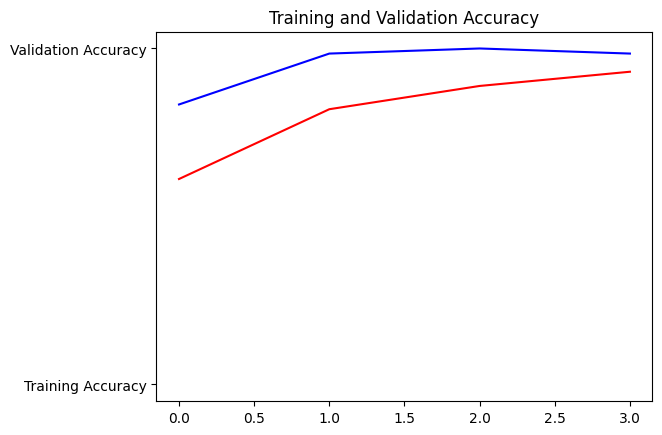

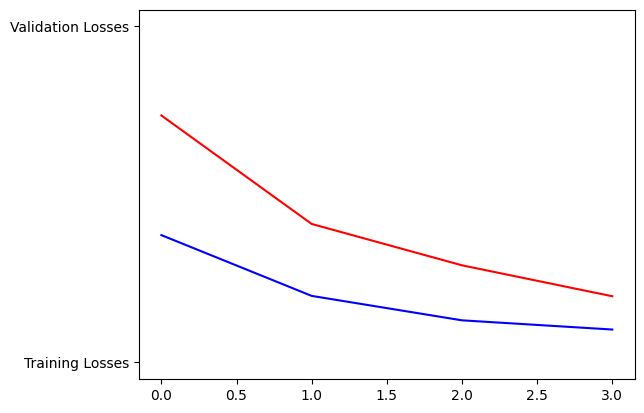

In [ ]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

In [ ]:
validation_results = model.evaluate(validation_gen)

print("Validation Loss: {:.1f}%".format(validation_results[0] * 100))
print("Validation Accuracy: {:.1f}%".format(validation_results[1] * 100))

predictions = model.predict(validation_gen)
# Check the shape of the predictions
print("Shape of predictions:", predictions.shape)

17/17 [==============================] - 3s 156ms/step - loss: 0.0980 - accuracy: 0.9848
Validation Loss: 9.8%
Validation Accuracy: 98.5%
17/17 [==============================] - 3s 96ms/step
Shape of predictions: (66, 2)


# 5. Saving Model

saving model into .pb and .h5

In [ ]:
# Save Model
os.chdir("/content/drive/MyDrive/Machine Learning/model")
model_dir = '/content/drive/MyDrive/Machine Learning/model/'
tf.saved_model.save(model, model_dir)
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


converting .pb into .tflite

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir=model_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
q_tflite_model = converter.convert()
q_tflite_model_file = pathlib.Path('./quantized_model.tflite')
q_tflite_model_file.write_bytes(q_tflite_model)

3301960